## Sumbit example

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector


In [2]:
df = pd.read_csv("/kaggle/input/mai-ml-lab-1-biro/train.csv")
df.head(5)

Unnamed: 0            category     clicks     likes  buys  4xx_errors  \
0        6622                ecom  6488536.0       NaN     0       82221   
1        2047  information_source   874840.0   21100.0     0       12872   
2        1118  information_source   571210.0   94707.0     0           0   
3        4992                news    89534.0     924.0     0         834   
4        9970  information_source  1043953.0  289288.0     0       58375   

   5xx_errors complaints_count  average_dwelltime  source_attractiveness  \
0           0                0          18.450527               0.461750   
1           0                0          10.721619              -0.022317   
2        7420                0           1.922243               0.046396   
3           0                0           2.149243              -0.093360   
4       20260             3948           3.764965               0.027303   

            date_of_registration  
0  2020-04-21 16:04:41.817367072  
1  2024-07-19 23:50:07.268931816  
2  2024-07-13 16:35:54.794883135  
3  2024-09-10 21:29:14.006315095  
4  2024-05-26 11:07:15.950527838

 дропнем все лишнее и приведём формат даты к годам

In [3]:
df = df.drop(df.columns[0], axis=1)
df["years_of_existing"] = (pd.Timestamp.today() - pd.to_datetime(df["date_of_registration"])) / pd.Timedelta(days=365)
df = df.drop("date_of_registration", axis=1)

df['complaints_count'] = df['complaints_count'].replace('-', np.nan)
df = df.dropna(subset=['clicks', 'likes', 'complaints_count'])

print(df.info())

df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 6550 entries, 1 to 7998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               6550 non-null   object 
 1   clicks                 6550 non-null   float64
 2   likes                  6550 non-null   float64
 3   buys                   6550 non-null   int64  
 4   4xx_errors             6550 non-null   int64  
 5   5xx_errors             6550 non-null   int64  
 6   complaints_count       6550 non-null   object 
 7   average_dwelltime      6550 non-null   float64
 8   source_attractiveness  6550 non-null   float64
 9   years_of_existing      6550 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 562.9+ KB
None


category     clicks     likes  buys  4xx_errors  5xx_errors  \
1  information_source   874840.0   21100.0     0       12872           0   
2  information_source   571210.0   94707.0     0           0        7420   
3                news    89534.0     924.0     0         834           0   
4  information_source  1043953.0  289288.0     0       58375       20260   
6                porn    99712.0       0.0     0           0       15178   

  complaints_count  average_dwelltime  source_attractiveness  \
1                0          10.721619              -0.022317   
2                0           1.922243               0.046396   
3                0           2.149243              -0.093360   
4             3948           3.764965               0.027303   
6             3725          20.786928               0.063572   

   years_of_existing  
1           0.245978  
2           0.263242  
3           0.101040  
4           0.395375  
6           1.480928

<Axes: >

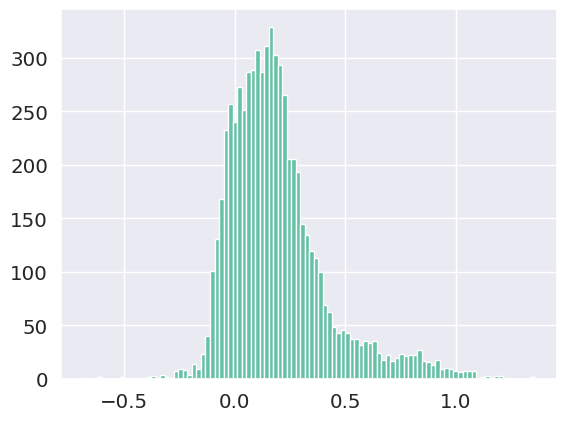

In [4]:
df['source_attractiveness'].hist(bins=100)


распределение близкое к нормальному с центром ~0.2

In [5]:
df['source_attractiveness'].mean(), df['source_attractiveness'].median()

(0.19174267491845015, 0.1542287349502777)

медиана расположена левее среднего, распределение смещено вправо

In [6]:
train, test = train_test_split(df, test_size=0.2)


In [7]:
print(train.shape)

(5240, 10)


In [8]:
print(test.shape)

(1310, 10)


In [9]:
df.head(5)

category     clicks     likes  buys  4xx_errors  5xx_errors  \
1  information_source   874840.0   21100.0     0       12872           0   
2  information_source   571210.0   94707.0     0           0        7420   
3                news    89534.0     924.0     0         834           0   
4  information_source  1043953.0  289288.0     0       58375       20260   
6                porn    99712.0       0.0     0           0       15178   

  complaints_count  average_dwelltime  source_attractiveness  \
1                0          10.721619              -0.022317   
2                0           1.922243               0.046396   
3                0           2.149243              -0.093360   
4             3948           3.764965               0.027303   
6             3725          20.786928               0.063572   

   years_of_existing  
1           0.245978  
2           0.263242  
3           0.101040  
4           0.395375  
6           1.480928

In [10]:
categorial_features = ['category'] # категориальный признак
real_features = ['clicks', 'likes', 'buys', '4xx_errors', '5xx_errors', 'complaints_count', 'average_dwelltime', 'years_of_existing'] # вещественные
target_features = 'source_attractiveness' # целевой

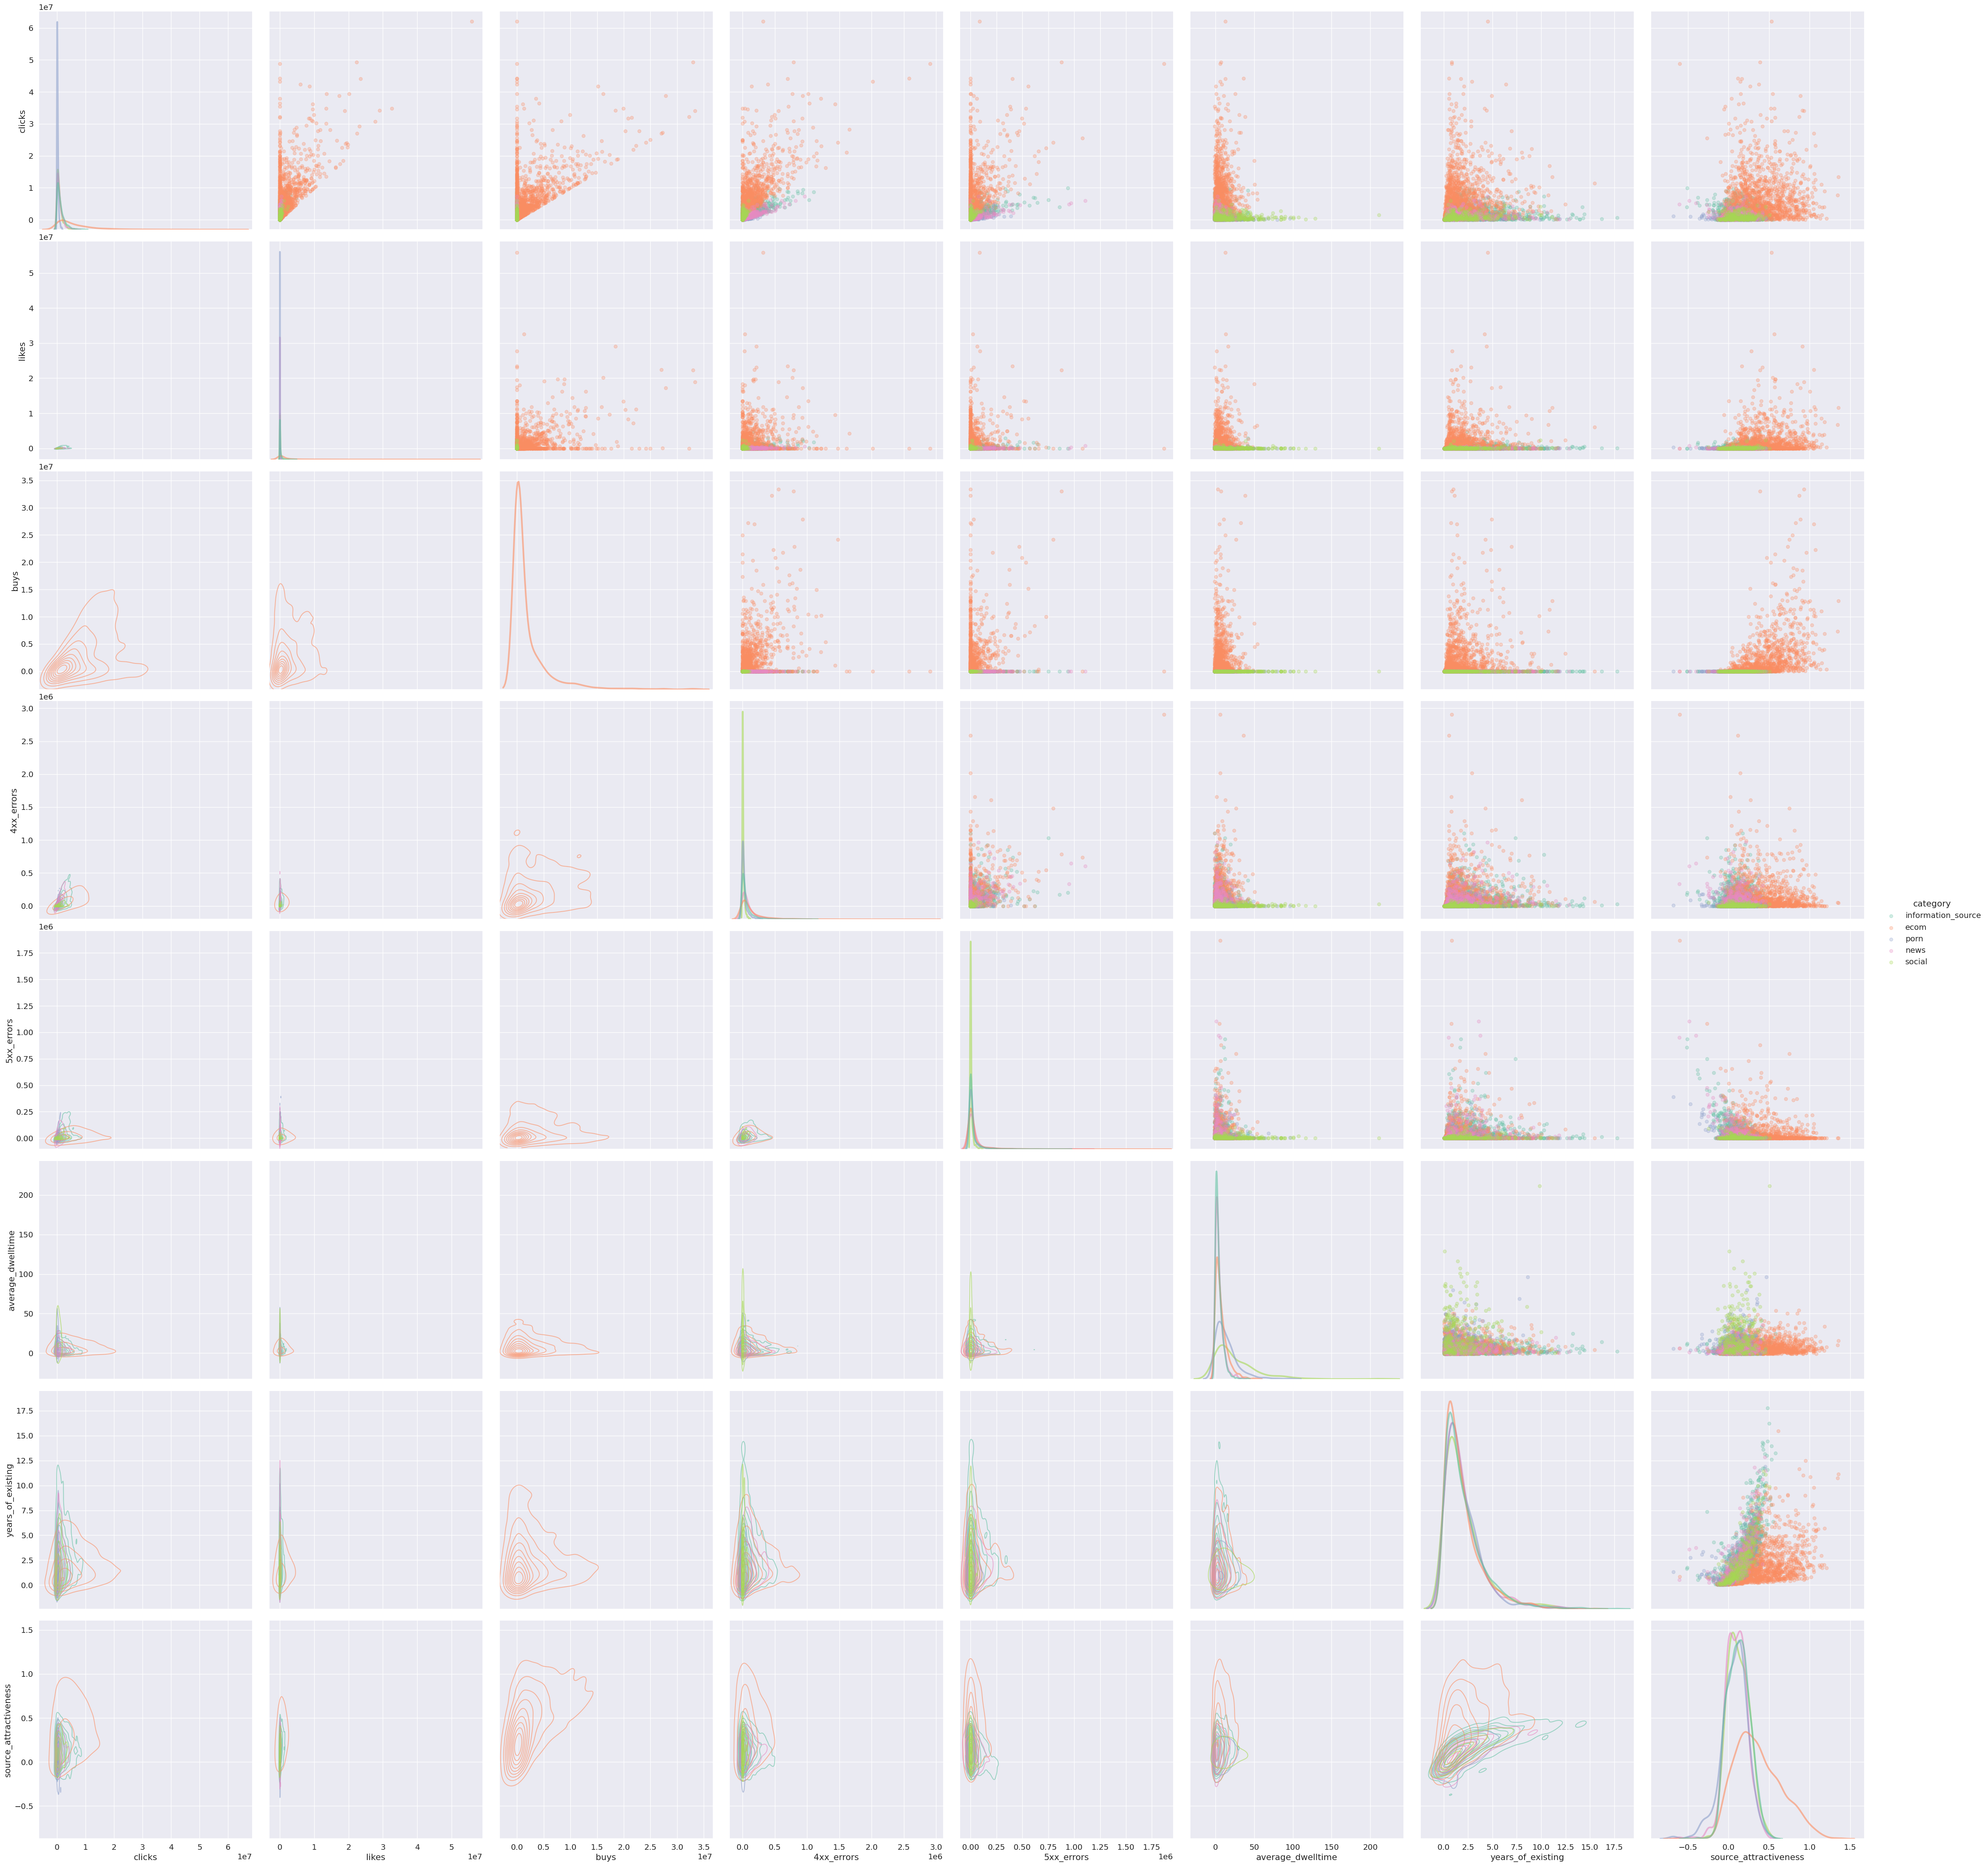

In [11]:
import warnings
warnings.filterwarnings('ignore')
for hue in categorial_features:
    g = sns.PairGrid(train[[*(real_features + [target_features]), hue]], hue=hue, diag_sharey=False, height=6)
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
    g.add_legend()

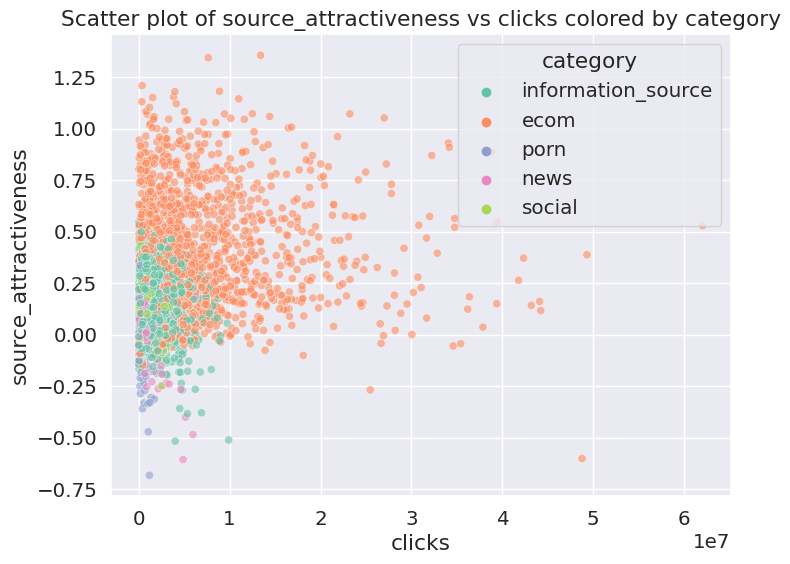

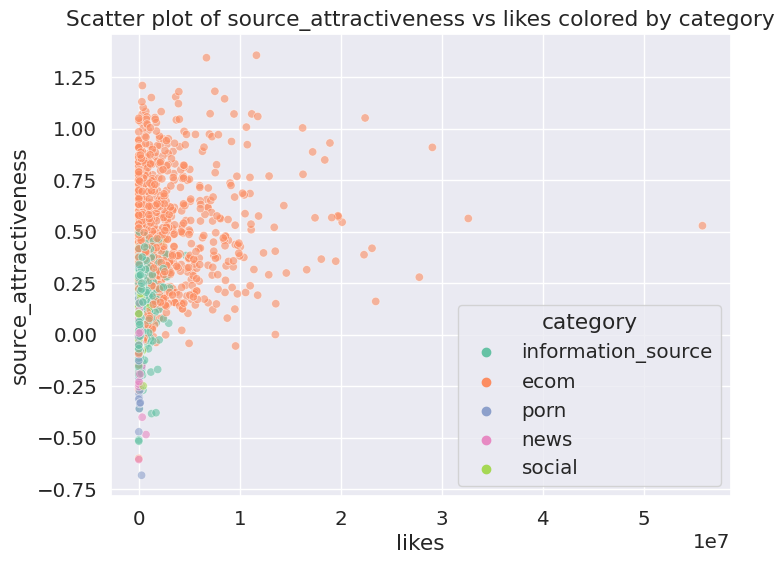

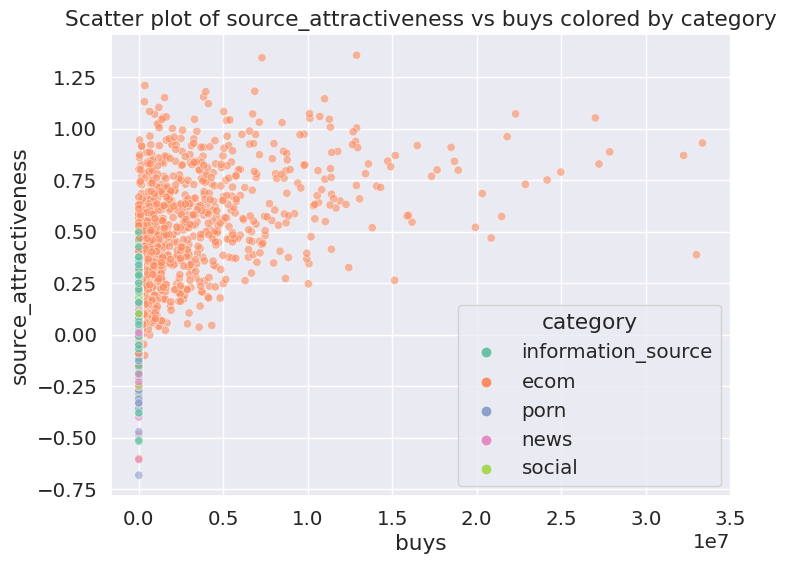

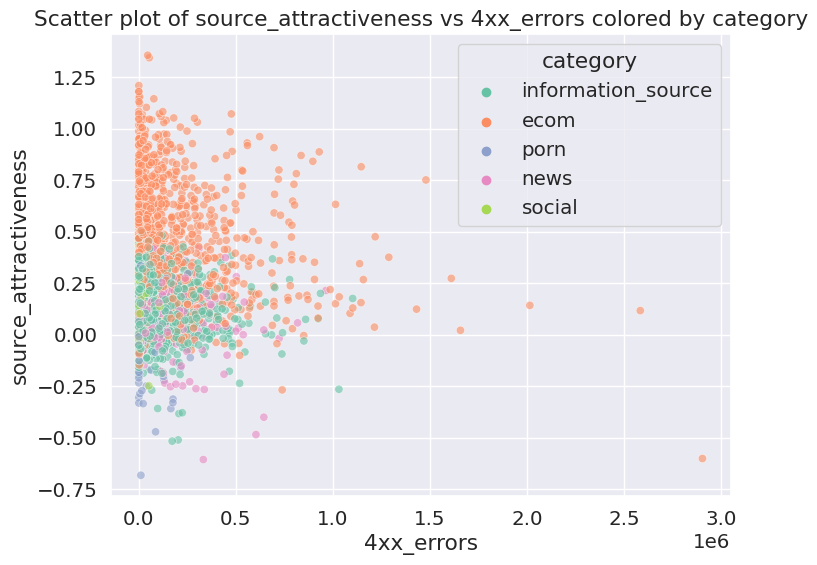

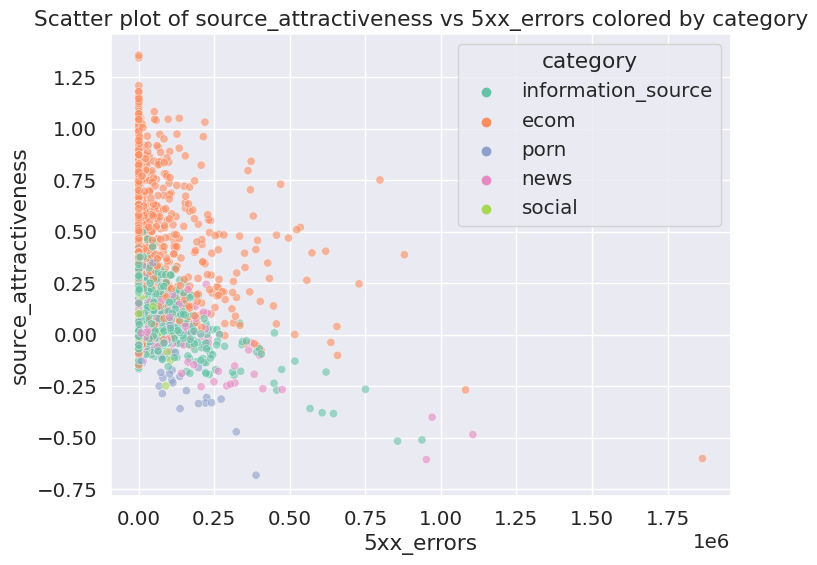

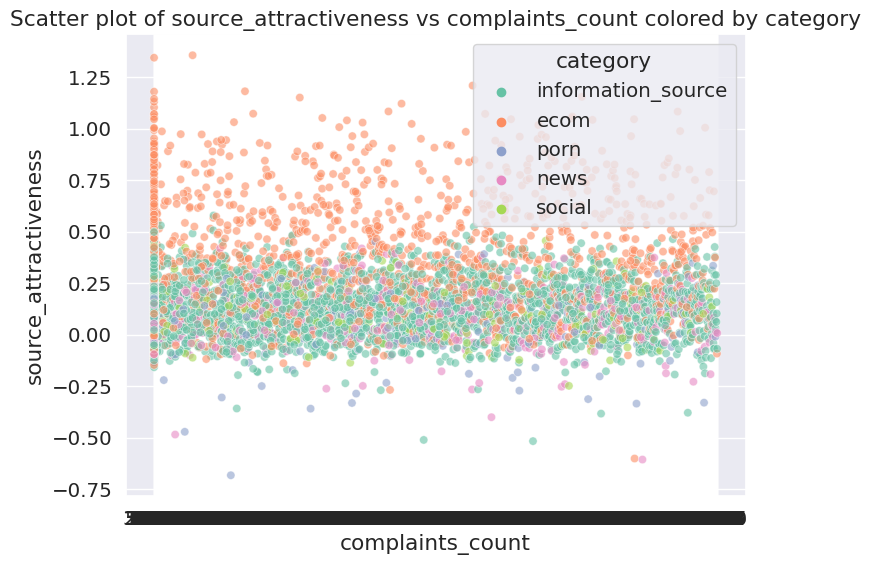

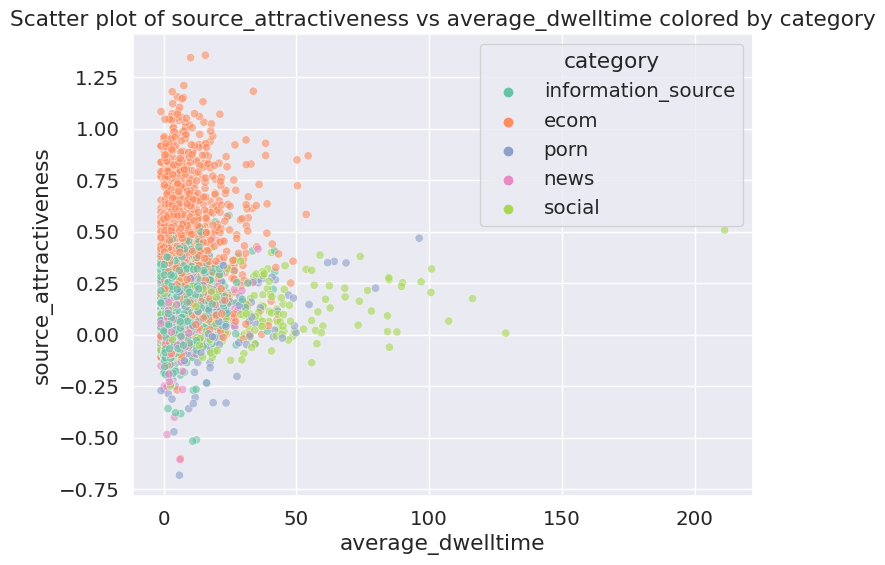

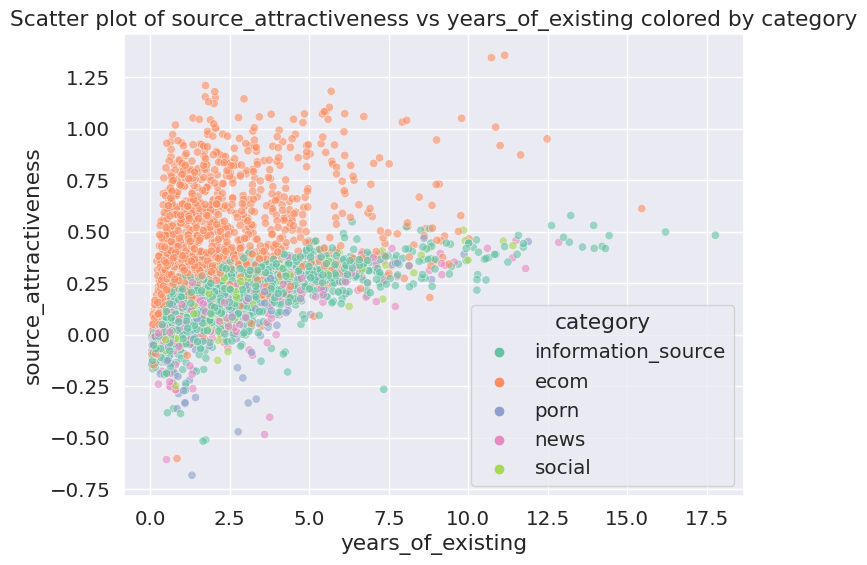

In [12]:
for hue in categorial_features:
    for feature in real_features:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=train, x=feature, y=target_features, hue=hue, alpha=0.6)
        plt.title(f'Scatter plot of {target_features} vs {feature} colored by {hue}')
        plt.xlabel(feature)
        plt.ylabel(target_features)
        plt.legend(title=hue)
        plt.show()

наибольшее количество кликов собирают новостные сайты, аналогично с лайками

больше всего ошибок в соцсетях

если судить по распределению, то наибольшую привлекательность для пользователей имеют интернет магазины - важный признак, то же самое можно увидеть и на точечных диаграммах, интернет магазины смещены вверх

можно увидеть некоторую зависимость между 4хх и 5хх ошибками. Чем больше, тем мерьше привлекательность домена

на привлекательность соцсетей влияет время, проведённое на них

также на привлекательность источника влияет время существования. Чем дольше - тем лучше


In [13]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
train_cat = encoder.fit_transform(train[categorial_features])
train_cat

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [14]:
encoder.categories_

[array(['ecom', 'information_source', 'news', 'porn', 'social'],
       dtype=object)]

In [15]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(5240, 12)

In [16]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train, train[target_features])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model1 = Ridge(
    alpha=0.1,
    fit_intercept=True,
    max_iter=200,
    tol=1e-4,
    solver='auto'
)
model1.fit(X_train, train[target_features])

model2 = Lasso(
    alpha=0.05,
    fit_intercept=True,
    max_iter=200,
    tol=1e-4,
    precompute=True,
    warm_start=False,
    positive=False
)
model2.fit(X_train, train[target_features])

model3 = ElasticNet(
    alpha=0.05,
    l1_ratio=0.6,
    fit_intercept=True,
    max_iter=200,
    tol=1e-4,
    precompute=True,
    warm_start=False,
    positive=False
)
model3.fit(X_train, train[target_features])

ElasticNet(alpha=0.05, l1_ratio=0.6, max_iter=200, precompute=True)

In [17]:
print("без регуляризации:", model.coef_)
print()
print("Ridge:", model1.coef_)
print()
print("Lasso:", model2.coef_)
print()
print("ElasticNet:", model3.coef_)

без регуляризации: [-1.54715066e-08  2.16656957e-08  4.70799424e-08  1.06558225e-07
  2.11992624e-07 -3.66482209e-06  1.82455753e-03  5.17118008e-02
 -2.01939368e-01 -2.27645350e-01 -2.73314085e-01 -2.51381000e-01]

Ridge: [-0.07398311  0.04569851  0.10570993  0.01659499  0.01621844 -0.05972525
  0.01895541  0.1059216  -0.10095751 -0.06931719 -0.05880342 -0.05672227]

Lasso: [ 0.          0.          0.06523913 -0.         -0.         -0.
  0.          0.05208244 -0.00117978 -0.         -0.         -0.        ]

ElasticNet: [ 0.          0.00902792  0.07853661 -0.         -0.01557905 -0.0009213
  0.          0.07111185 -0.0173647  -0.00051911 -0.         -0.        ]


In [18]:
model.intercept_

0.23302971644082565

In [19]:
test_cat = encoder.transform(test[categorial_features])
X_test = np.hstack([test[real_features], test_cat])
test_preds = model.predict(X_test)

X_test = scaler.transform(X_test)

test_preds1 = model1.predict(X_test)
test_preds2 = model2.predict(X_test)
test_preds3 = model2.predict(X_test)

In [20]:
print("без регуляризации MSE", metrics.mean_squared_error(test[target_features], test_preds, squared=False))
print("без регуляризации MAE", metrics.mean_absolute_error(test[target_features], test_preds))
print()
print("Ridge MSE", metrics.mean_squared_error(test[target_features], test_preds1, squared=False))
print("RIdge MAE", metrics.mean_absolute_error(test[target_features], test_preds1))
print()
print("Lasso MSE", metrics.mean_squared_error(test[target_features], test_preds2, squared=False))
print("Lasso MAE", metrics.mean_absolute_error(test[target_features], test_preds2))
print()
print("ElasticNet MSE", metrics.mean_squared_error(test[target_features], test_preds3, squared=False))
print("ElasticNet MAE", metrics.mean_absolute_error(test[target_features], test_preds3))
print()

без регуляризации MSE 0.12839342753750924
без регуляризации MAE 0.08870422032456476

Ridge MSE 0.1283949205101792
RIdge MAE 0.08870388071950362

Lasso MSE 0.18932643512395653
Lasso MAE 0.13048264687146358

ElasticNet MSE 0.18932643512395653
ElasticNet MAE 0.13048264687146358



## Submit

Принимает на вход путь к набору данных в формате `.csv`

In [21]:
def createNewFeature(df):
    data = df.copy()
    data['complaints_count'] = data['complaints_count'].replace('-', np.nan)
    data['complaints_count'] = pd.to_numeric(data['complaints_count'])
    data["years_of_existing"] = (pd.Timestamp.today() - pd.to_datetime(data["date_of_registration"])) / pd.Timedelta(days=365)
    data.drop("date_of_registration", axis=1, inplace=True)
    return data

df = pd.read_csv("/kaggle/input/mai-ml-lab-1-biro/train.csv", index_col=0)
df_test = pd.read_csv("/kaggle/input/mai-ml-lab-1-biro/test.csv", index_col=0)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(missing_values=np.nan, strategy='mean'), make_column_selector(dtype_exclude="object")),
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include="object"))
    ], n_jobs=-1)
    
    
    
model = Pipeline(steps=[
    ('new_features', FunctionTransformer(createNewFeature)),
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=0.001))
])

X_train, X_test, y_train, y_test = train_test_split(df.drop("source_attractiveness", axis=1), df["source_attractiveness"], stratify=df["category"], random_state=228)

model.fit(X_train, y_train)
metrics.mean_squared_error(y_test, model.predict(X_test))

0.015946934777981585

In [22]:
model.fit(df.drop("source_attractiveness", axis=1), df["source_attractiveness"])

Pipeline(steps=[('new_features',
                 FunctionTransformer(func=<function createNewFeature at 0x7e49fffc3b50>)),
                ('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e4a04027280>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e4a10a9c040>)])),
                ('scaler', StandardScaler()), ('model', Ridge(alpha=0.001))])

In [23]:
data = {
    "source_attractiveness": model.predict(df_test)
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")
submit

source_attractiveness
0                  0.398611
1                  0.040064
2                  0.566685
3                  0.321002
4                  0.310078
...                     ...
1995               0.227833
1996               0.329387
1997              -0.021944
1998               0.284880
1999               0.077967

[2000 rows x 1 columns]